In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans

import common.loss_utils as loss_utils

import sys
sys.path.append('../utae-paps')
from src.backbones import utae_mod

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
EXPECTED = 1


In [5]:
_cluster_centers = np.array(
  [[494.5411  ],
  [125.75024 ],
  [321.87573 ],
  [192.39209 ],
  [256.2398  ],
  [ 55.367462],
  [605.27045 ],
  [405.747   ]], dtype=np.float32
)

_KM = KMeans()
_KM.cluster_centers_ = _cluster_centers
_KM._n_threads = 1

_MEDIAN_PIXEL = 216.0
_IQR = 201.0

def transform(x):
    return (x - _MEDIAN_PIXEL) / _IQR

def transform_y(y):
    y = y.astype(np.float32)
    y_grouped = _KM.predict(y.reshape(-1,1))
    y_grouped = y_grouped.reshape(y.shape)
    return y_grouped

In [7]:
model = utae_mod.UTAE(
    input_dim=1, # 10 for paper
    encoder_widths=[64, 64, 64, 128],
    decoder_widths=[32, 32, 64, 128],
    out_conv=[32, len(_cluster_centers)], # [32, 20] for paper
    str_conv_k=4,
    str_conv_s=2,
    str_conv_p=1,
    agg_mode="att_group",
    encoder_norm="group",
    n_head=16,
    d_model=256,
    d_k=4,
    encoder=False,
    return_maps=False,
    pad_value=0,
    padding_mode="reflect",
)

model.load_state_dict(torch.load("weights/utae_300d_epochs=11_loss=0.1083.pt"))
model = model.to(DEVICE)


In [8]:
p = pathlib.Path('climatehack-submission/features.npz')
t = pathlib.Path('climatehack-submission/targets.npz')
feats = np.load(p)
targs = np.load(t)

In [9]:
x = feats['data']
y = targs['data']

In [10]:
x.shape, y.shape

((200, 12, 128, 128), (200, 24, 64, 64))

In [11]:
# get accuracy
model.eval()

running_correct = 0
running_total = 0
bp = torch.Tensor([list(range(12)) for _ in range(1)]).to(DEVICE)
for i, (xi, yi) in enumerate(tqdm.tqdm(zip(x, y), total=len(x))):
    xi = torch.FloatTensor(transform(xi)).to(DEVICE)
    yi = torch.LongTensor(transform_y(yi[:EXPECTED])).to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=0)
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi, batch_positions=bp)
    
    # remove the batch and satellite channel dimension from the prediction
    preds = torch.squeeze(preds, dim=2)
    preds = torch.squeeze(preds, dim=0)
    # get argmax of the predicted labels
    preds = torch.argmax(preds, dim=0)
    running_correct += (preds == yi).sum()
    running_total += yi.reshape(-1).shape[0]
    

100%|██████████| 200/200 [00:15<00:00, 13.17it/s]


In [12]:
running_correct / running_total

tensor(0.6481, device='cuda:0')

In [13]:
_means = torch.FloatTensor(_cluster_centers).to(DEVICE)
_means = torch.unsqueeze(torch.unsqueeze(_means, 0), 3)

def get_img(preds):
    a = torch.exp(preds)
    v = a.sum(dim=1)
    e = a / torch.unsqueeze(v, 1)
    r = torch.sum(e * _means, axis=1)
    return r

In [14]:
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=EXPECTED)


In [ ]:
with torch.no_grad():
    preds = model(xi, batch_positions=bp)

In [25]:
model.eval()

losses = []
bp = torch.Tensor([list(range(12)) for _ in range(1)]).to(DEVICE)
pbar = tqdm.tqdm(zip(x, y), total=len(x))
for i, (xi, yi) in enumerate(pbar):
    xi = torch.FloatTensor(transform(xi)).to(DEVICE)
    yi = torch.FloatTensor(yi[:EXPECTED]).to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=0)
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi, batch_positions=bp)
    
    # remove the batch and satellite channel dimension from the prediction
    preds = get_img(preds)
    
#     missing = EXPECTED - FORECAST
#     # just do persistence
#     missing_pred = inv_transform(xi[:,-1,:,32:96,32:96])
#     missing_pred = torch.squeeze(missing_pred)
#     missing_pred = torch.tile(missing_pred, (missing, 1, 1))
#     # stack them together
#     preds = torch.cat([preds, missing_pred], dim=0)

    # OR, just test the ones we did
#     yi = yi[:FORECAST]
    
    # also need to do this
    preds = torch.unsqueeze(preds, 0)
    yi = torch.unsqueeze(yi, 0)
    loss = criterion(preds, yi)
    losses.append(loss.item())
    
    if i % 10:
        avg = np.mean(losses)
        avg = round(avg, 4)
        pbar.set_description(f'Avg: {avg}')

Avg: 0.7818: 100%|██████████| 200/200 [00:12<00:00, 15.64it/s]


In [26]:
np.mean(losses) # DEBUG!

0.781847922205925

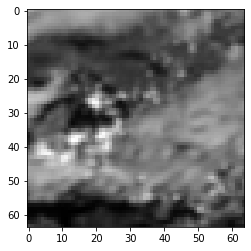

In [27]:
plt.imshow(xi[0,-1,0][32:96,32:96].detach().cpu().numpy(), cmap='gray')

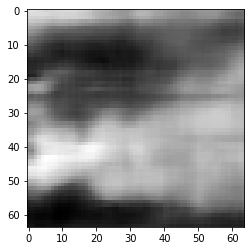

In [28]:
plt.imshow(preds[0,0].detach().cpu().numpy(), cmap='gray')

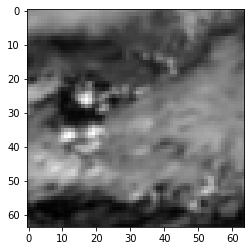

In [29]:
plt.imshow(yi[0,0].detach().cpu().numpy(), cmap='gray')